## How `xgbse` works

In this Notebook, we'll introduce you to `xgbse` and show some features. 

In [1]:
# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# models and metrics
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgbse.metrics import concordance_index
from xgbse.non_parametric import get_time_bins
from xgbse import (
    XGBSEKaplanNeighbors,
    XGBSEKaplanTree,
    XGBSEDebiasedBCE,
    XGBSEBootstrapEstimator
)
from xgbse.converters import (
    convert_data_to_xgb_format,
    convert_to_structured
)

# better plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('bmh')

# setting seed
np.random.seed(42)

In [2]:
# to easily plot confidence intervals

def plot_ci(mean, upper_ci, lower_ci, i=42, title='Probability of survival $P(T \geq t)$'):
    
    # plotting mean and confidence intervals
    plt.figure(figsize=(12, 4), dpi=120)
    plt.plot(mean.columns,mean.iloc[i])
    plt.fill_between(mean.columns, lower_ci.iloc[i], upper_ci.iloc[i], alpha=0.2)

    plt.title(title)
    plt.xlabel('Time [days]')
    plt.ylabel('Probability')
    plt.tight_layout()

In [3]:
# to write data as markdown for publication

def df_to_markdown(df, float_format='%.2g'):
    """
    Export a pandas.DataFrame to markdown-formatted text.
    DataFrame should not contain any `|` characters.
    """
    from os import linesep
    df.columns = df.columns.astype(str)
    return linesep.join([
        '|'.join(df.columns),
        '|'.join(4 * '-' for i in df.columns),
        df.to_csv(sep='|', index=False, header=False, float_format=float_format)
    ]).replace('|', ' | ')

## Parameters

Let us define parameters for the underlying `xgboost` models, the stacked Logistic Regression and kNN model `xgbse` provides.

In [4]:
## pre selected params for models ##

PARAMS_XGB_AFT = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'aft_loss_distribution': 'normal',
    'aft_loss_distribution_scale': 1.0,
    'tree_method': 'hist', 
    'learning_rate': 5e-2, 
    'max_depth': 8, 
    'booster':'dart',
    'subsample':0.5,
    'min_child_weight': 50,
    'colsample_bynode':0.5
}

PARAMS_XGB_COX = {
    'objective': 'survival:cox',
    'tree_method': 'hist', 
    'learning_rate': 5e-2, 
    'max_depth': 8, 
    'booster':'dart',
    'subsample':0.5,
    'min_child_weight': 50, 
    'colsample_bynode':0.5
}

PARAMS_TREE = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist', 
    'max_depth': 100, 
    'booster':'dart', 
    'subsample': 1.0,
    'min_child_weight': 50, 
    'colsample_bynode': 1.0
}

PARAMS_LR = {
    'C': 1e-3,
    'max_iter': 500
}

N_NEIGHBORS = 50

TIME_BINS = np.arange(15, 315, 15)

## Data

Let us use data from the Molecular Taxonomy of Breast Cancer International Consortium (METABRIC) as a benchmark and starting point.

In [5]:
# importing dataset from pycox package
from pycox.datasets import metabric

# getting data
df = metabric.read_df()

# splitting to X, T, E format
X = df.drop(['duration', 'event'], axis=1)
y = convert_to_structured(df['duration'], df['event'])

# splitting between train, and validation 
(X_train, X_valid,
 y_train, y_valid) = \
train_test_split(X, y, test_size=0.2, random_state=42)

## 1. What `xgbse` tries to solve

XGBoost survival analysis implementation shows great predictive power and high computational efficiency, as shown by the competitive performance on the metabric dataset ([state of the art results](file:///Users/guilherme.marmerola/Downloads/s12874-018-0482-1.pdf) show C-index around `0.654`):

In [6]:
# converting to xgboost format
dtrain = convert_data_to_xgb_format(X_train, y_train, 'survival:aft')
dval = convert_data_to_xgb_format(X_valid, y_valid, 'survival:aft')

# training model
bst = xgb.train(
    PARAMS_XGB_AFT,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dval, 'val')],
    verbose_eval=0
)

# predicting and evaluating
preds = bst.predict(dval)
cind = concordance_index(y_valid, -preds, risk_strategy='precomputed')
print(f"C-index: {cind:.3f}")
print(f"Average survival time: {preds.mean():.0f} days")

C-index: 0.657
Average survival time: 163 days


However, C-index is a measurement of ordering: it checks if the model assigns higher risk to individuals that survived less, but not if the expected time or survival probabilities are calibrated and unbiased (just like AUC). 

For instance, using `survival:aft` as objective, we can tweak `aft_loss_distribution_scale` and build models with very different average predicted survival times, while maintaing good C-indexes: 

In [7]:
# saving predictions to plot later
preds_dict = {}

# loop to show different scale results
for scale in [1.5, 1.0, 0.5]:
    
    # chaning parameter
    PARAMS_XGB_AFT['aft_loss_distribution_scale'] = scale
    
    # training model
    bst = xgb.train(
        PARAMS_XGB_AFT,
        dtrain,
        num_boost_round=1000,
        early_stopping_rounds=10,
        evals=[(dval, 'val')],
        verbose_eval=0
    )

    # predicting and evaluating
    preds = bst.predict(dval)
    cind = concordance_index(y_valid, -preds, risk_strategy='precomputed')

    preds_dict[scale] = preds

    print(f"aft_loss_distribution_scale: {scale}")
    print(f"C-index: {cind:.3f}")
    print(f"Average survival time: {preds.mean():.0f} days")
    print("----")

aft_loss_distribution_scale: 1.5
C-index: 0.638
Average survival time: 194 days
----
aft_loss_distribution_scale: 1.0
C-index: 0.657
Average survival time: 163 days
----
aft_loss_distribution_scale: 0.5
C-index: 0.647
Average survival time: 127 days
----


With C-indexes varying at most `0.003` we could observe a swing of 78 days in the average survival time. 

If we plot the results against a Kaplan Meier estimator we can get a clearer picture:

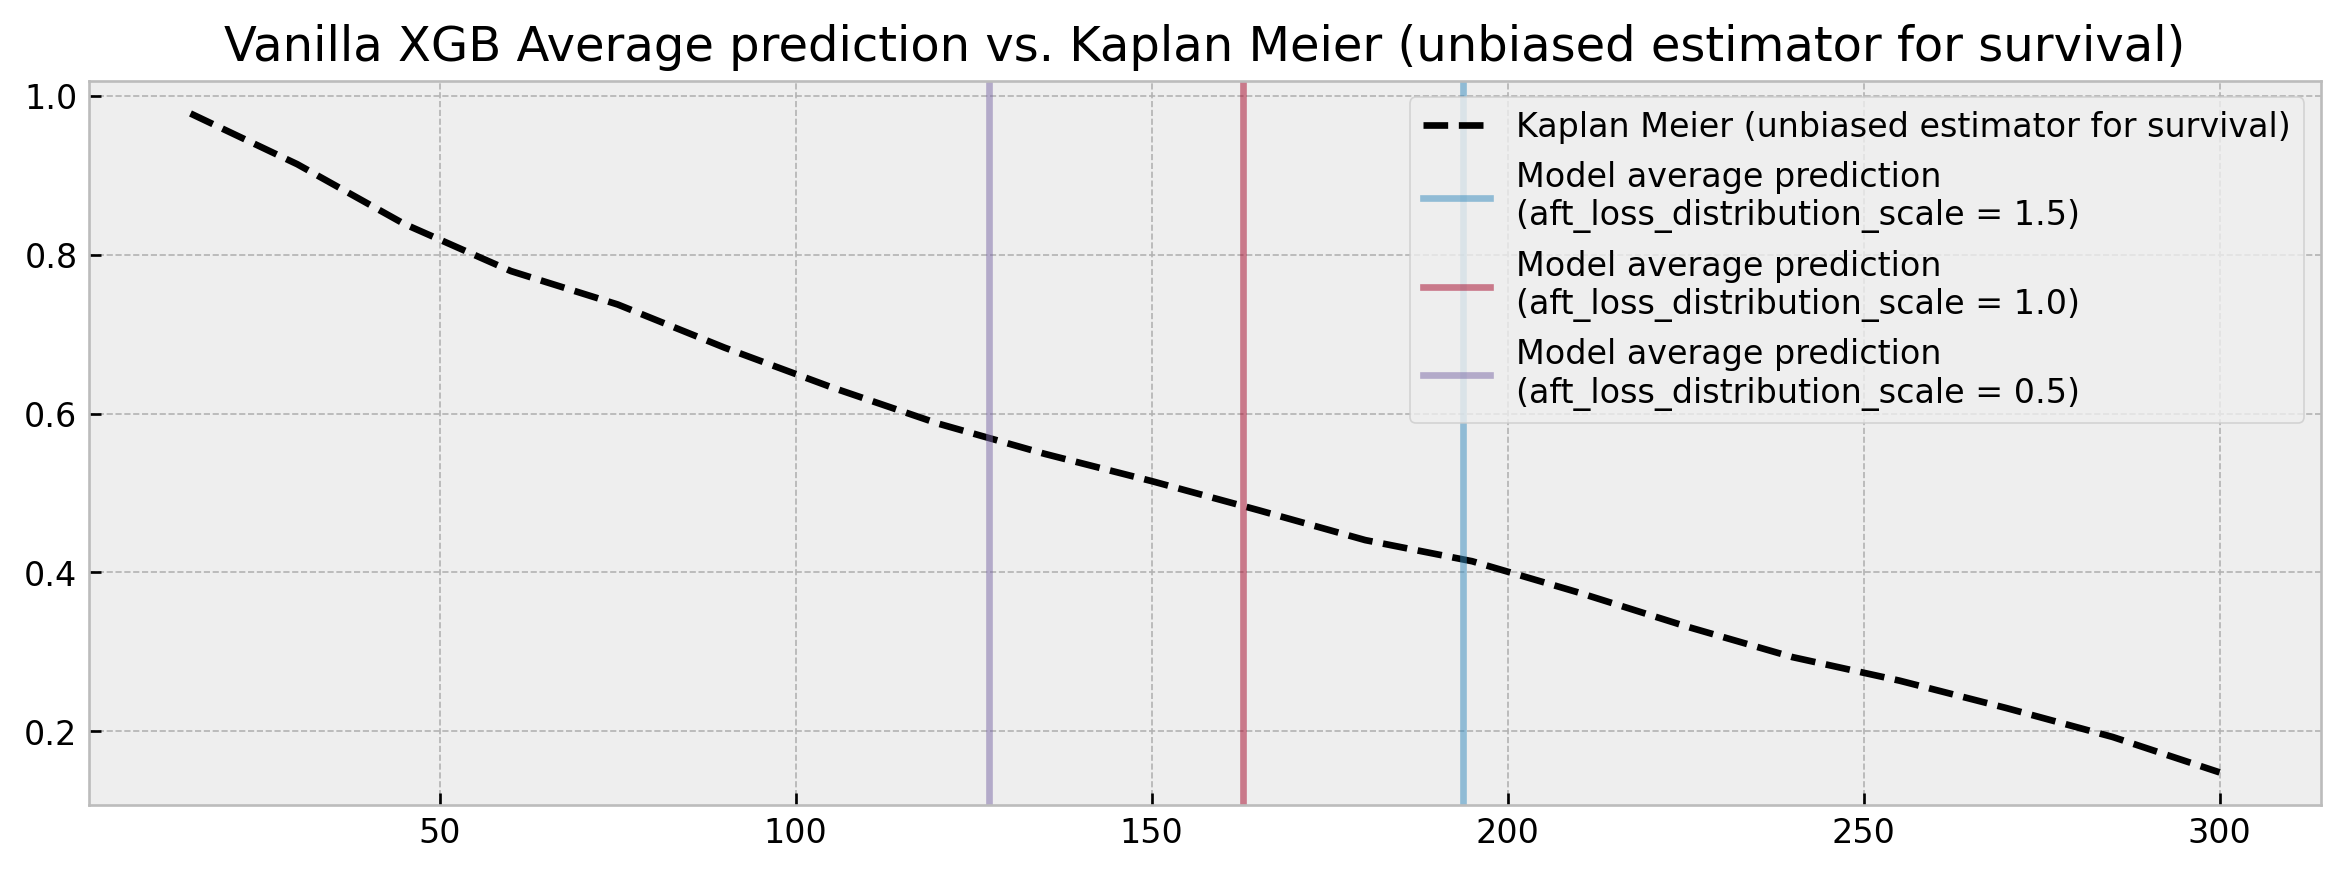

In [8]:
from xgbse.non_parametric import calculate_kaplan_vectorized

mean, high, low = calculate_kaplan_vectorized(
    y['c2'].reshape(1,-1),
    y['c1'].reshape(1,-1),
    TIME_BINS
)

plt.figure(figsize=(12,4), dpi=120)
plt.plot(mean.columns, mean.iloc[0], 'k--', label='Kaplan Meier (unbiased estimator for survival)')

for i, scale in enumerate([1.5, 1.0, 0.5]):
    plt.axvline(
        preds_dict[scale].mean(),
        label=f'Model average prediction\n(aft_loss_distribution_scale = {scale})',
        linewidth=2, 
        alpha=0.5,
        color=f'C{i}'
    )

plt.title('Vanilla XGB Average prediction vs. Kaplan Meier (unbiased estimator for survival)')
plt.legend()

Changing to the `survival:cox` objective does not solve the issue either, as the model outputs the relative risk:

In [9]:
# converting to xgboost format
dtrain = convert_data_to_xgb_format(X_train, y_train, 'survival:cox')
dval = convert_data_to_xgb_format(X_valid, y_valid, 'survival:cox')

# training model
bst = xgb.train(
    PARAMS_XGB_COX,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dval, 'val')],
    verbose_eval=0
)

# predicting and evaluating
preds = bst.predict(dval)
cind = concordance_index(y_valid, preds, risk_strategy='precomputed')
print(f"C-index: {cind:.3f}")
print(f"Model predictions: {preds[:5]}")

C-index: 0.658
Model predictions: [1.2216167  0.9939259  1.7366916  0.45822883 0.5640862 ]


`xgbse` aims to solve this issues and add a layer of statistical rigor to XGBoost survival analysis implementation. For example, `XGBEmbedKaplanNeighbors` shows a slight decrease in C-index, but does not suffer from the big prediction swings anymore (as measured by the average probability of event at 30, 90, and 150 days):

In [10]:
# saving predictions to plot later
preds_dict = {}

# loop to show different scale results
for scale in [1.5, 1.0, 0.5]:
    
    # chaning parameter
    PARAMS_XGB_AFT['aft_loss_distribution_scale'] = scale
    
    # training model
    xgbse_model = XGBSEKaplanNeighbors(PARAMS_XGB_AFT, n_neighbors=30)
    xgbse_model.fit(
        X_train, y_train,
        validation_data = (X_valid, y_valid),
        early_stopping_rounds=10,
        time_bins=TIME_BINS
    )

    # predicting and evaluating
    preds = xgbse_model.predict(X_valid)
    cind = concordance_index(y_valid, preds)
    avg_probs = preds[[30, 90, 150]].mean().values.round(4).tolist()
    
    preds_dict[scale] = preds
    
    print(f"aft_loss_distribution_scale: {scale}")
    print(f"C-index: {cind:.3f}")
    print(f"Average probability of survival at [30, 90, 150] days: {avg_probs}")
    print("----")

aft_loss_distribution_scale: 1.5
C-index: 0.640
Average probability of survival at [30, 90, 150] days: [0.9117, 0.6872, 0.5299]
----
aft_loss_distribution_scale: 1.0
C-index: 0.640
Average probability of survival at [30, 90, 150] days: [0.9101, 0.6884, 0.53]
----
aft_loss_distribution_scale: 0.5
C-index: 0.646
Average probability of survival at [30, 90, 150] days: [0.9179, 0.6989, 0.5332]
----


As measured by the average probability of survival in 30, 90 and 150 days the model is very stable, showing similar calibration results independently of `aft_loss_distribution_scale` choice, with slightly worse C-index results (decreases by about `0.010`). 

If we compare the average model prediction to a unbiased survival estimator such as Kaplan Meier we get very good results:

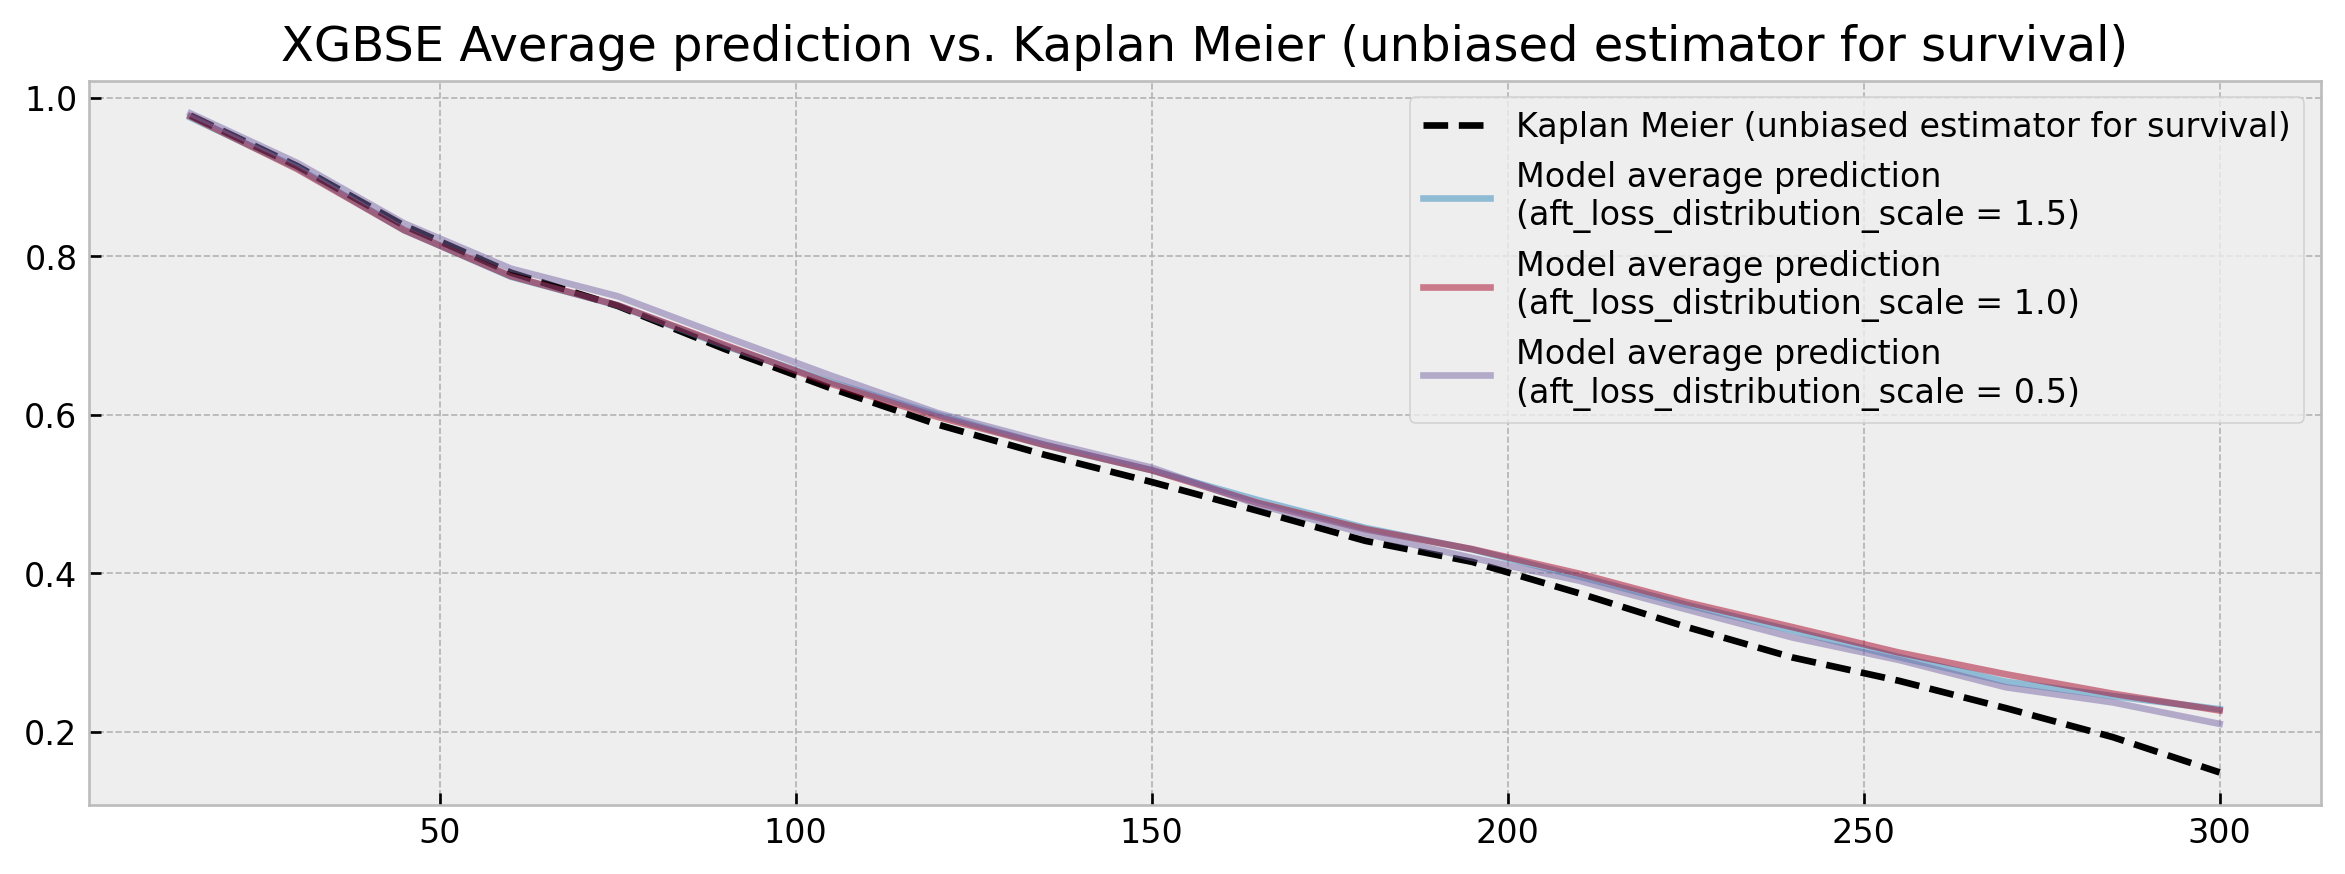

In [11]:
plt.figure(figsize=(12,4), dpi=120)
plt.plot(mean.columns, mean.iloc[0], 'k--', label='Kaplan Meier (unbiased estimator for survival)')

for scale in [1.5, 1.0, 0.5]:
    plt.plot(
        preds_dict[scale].columns,
        preds_dict[scale].mean(),
        label=f'Model average prediction\n(aft_loss_distribution_scale = {scale})',
        linewidth=2, alpha=0.5
    )

plt.title('XGBSE Average prediction vs. Kaplan Meier (unbiased estimator for survival)')
plt.legend()

Although is too harsh to claim that we solved the statistical rigor problem, we believe that the package can be a good, more statistically robust alternative to survival analysis.

2. ## How `xgbse` works: Leveraging `xgboost` as a feature transformer

Although in need of an extension for statistical rigor, `xgboost` is still a powerhouse. C-index results show that the model can capture a great deal of signal, being competitive with the state of the art. We just need to adapt how we use it.

Besides being leveraged for prediction tasks, Gradient Boosted Trees (GBTs) can also be used as ***feature transformers*** of the input data. Trees in the ensemble perform splits on features that discriminate the target, encoding the most relevant information for the task at hand in their structure. In particular, the terminal nodes (leaves) at each tree in the ensemble define a ***[sparse supervised feature transformation](http://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html) (embedding)*** of the input data.

This kind of *tree ensemble embedding* has very convenient properties:

1. **sparsity and high-dimensionality:** trees deal with nonlinearity and cast original features to a sparse, high-dimensional embedding. This allows a **Logistic Regression** trained on the embedding (as one-hot encoded leaf indices) to have comparable performance to the actual ensemble, with the added benefit of probability calibration (see [1], [2], and [3])

2. **supervision:** trees also work as a noise filter, performing splits only through features that have predictive power with regards to the target variable. Thus, the embedding actually has a lower intrinsic dimension than the input data. This mitigates the curse of dimensionality and allows a **K-Nearest Neighbor** model trained on the embedding (using hamming distance) to have comparable performance to the actual ensemble, with the added flexibility to apply any function over the neighbor-sets to get predictions, such as a Kaplan-Meier estimator (see [4])

We take advantage of these properties in different ways as we will show in the next subsections.

### *`XGBSEDebiasedBCE`: Logistic regressions on multiple time windows*

Our first approach, `XGBEmbedBCE`, takes inspiration from the multi-task logistic regression method in [5], the BCE approach in [6], and the probability calibration ideas from [1], [2] and [3].

It consists of training a set of binary classifiers that remove individuals as they are censored. The loss is the binary cross entropy of the survival estimates at a set of discrete time windows (which are defined by the user), with targets that are indicators of surviving each time.

<img src="../img/xgb_bce_diagram.svg">

The naive approach tends to give optimistic survival curves, due to the removal of censored individuals. Thus, we made some adaptations such that logistic regressions estimate the $d_i/n_i$ term in the [Kaplan-Meier formula](https://www.math.wustl.edu/~sawyer/handouts/greenwood.pdf) and then use the KM estimator to get nearly unbiased survival curves.

This way, we can get full survival curves from `xgboost`, and confidence intervals with minor adaptations (such as performing some rounds of bootstrap).

Training and scoring of logistic regression models is highly efficient, while also being performed in parallel through `joblib`, so the model can easily scale to millions of samples.

### *`XGBSEKaplanNeighbors`: Kaplan-Meier on nearest neighbors*

As explained in the previous section, even though the embedding produced by `xgboost` is sparse and high dimensional, its intrisic dimensionality actually should be lower than the input data. This enables us to "convert" `xgboost` into a nearest neighbor model, where we use hamming distance to define similar elements as the ones that co-ocurred the most at the ensemble terminal nodes. Then, at each neighbor-set we can get survival estimates with robust methods such as the Kaplan-Meier estimator.

<img src="../img/xgb_neighbors_diagram.svg">

We recommend using `dart` as the booster to prevent any tree to dominate variance in the ensemble and break the leaf co-ocurrence similarity logic. We built a high-performing implementation of the KM estimator to calculate several survival curves in a vectorized fashion, including upper and lower confidence intervals based on the Exponential Greenwood formula.

However, this method can be computationally expensive at scales of millions or several hundred thousands of samples, due to the nearest neighbor search, both on training (construction of search index) and scoring (actual search).

### *`XGBSEKaplanTree`: single tree, and Kaplan-Meier on its leaves*

As a simplification to `XGBEmbedKaplanNeighbors`, we also provide a single tree implementation. Instead of doing expensive nearest neighbor searches, we fit a single tree via `xgboost` and calculate KM curves at each of its leaves.

<img src="../img/xgb_tree_diagram.svg">

It is by far the most efficient implementation, able to scale to tens of millions of examples. At fit time, the tree is built and all KM curves are pre-calculated, so that at scoring time a simple query will suffice to get the model's estimates.

However, as we're fitting a single tree, predictive power may be worse. That could be a sensible tradeoff, but we also provide `XGBSEBootstrapEstimator`, a bootstrap abstraction where we can fit a forest of `XGBSEKaplanTree`s to improve accuracy.

## 3. `xgbse` usage

### *Basic usage*

The package follows `scikit-learn` API, with a minor adaptation to work with time and event data. The model outputs the probability of survival, in a `pd.Dataframe` where columns represent different times.

In [12]:
# fitting xgbse model
xgbse_model = XGBSEDebiasedBCE(PARAMS_XGB_AFT, PARAMS_LR)
xgbse_model.fit(X_train, y_train, time_bins=TIME_BINS)

# predicting
survival = xgbse_model.predict(X_valid)
survival.head()

,15,30,45,60,75,90,105,120,135,150,165,180,195,210,225,240,255,270,285,300
0,0.977568,0.842978,0.750908,0.637729,0.613100,0.549205,0.450750,0.409098,0.364436,0.337656,0.263954,0.226917,0.199384,0.172364,0.138512,0.121832,0.108394,0.081656,0.071765,0.050827
1,0.984025,0.875169,0.786462,0.710757,0.655218,0.580889,0.524670,0.462059,0.424532,0.386813,0.340509,0.317650,0.294130,0.258384,0.219236,0.191572,0.171756,0.125037,0.109117,0.074144
2,0.956139,0.801217,0.670124,0.615149,0.590839,0.526085,0.485746,0.409937,0.381565,0.358934,0.301316,0.270963,0.252414,0.220209,0.186899,0.167088,0.150223,0.114696,0.100308,0.069236
3,0.985819,0.945725,0.916262,0.868761,0.821777,0.771377,0.676728,0.626698,0.554914,0.513630,0.449575,0.393695,0.360922,0.321037,0.269895,0.228823,0.198666,0.154546,0.135259,0.098491
4,0.980591,0.915931,0.823416,0.762881,0.701403,0.660343,0.602814,0.561961,0.533532,0.509673,0.467751,0.443844,0.407292,0.370167,0.330419,0.286834,0.259437,0.199611,0.176401,0.117887


You can also get interval predictions using `return_interval_probs`:

In [13]:
# point predictions
interval_probs = xgbse_model.predict(X_valid, return_interval_probs=True)
interval_probs.head()

,15,30,45,60,75,90,105,120,135,150,165,180,195,210,225,240,255,270,285,300
0,0.022432,0.134590,0.092070,0.113179,0.024629,0.063895,0.098456,0.041651,0.044663,0.026780,0.073702,0.037037,0.027533,0.027020,0.033852,0.016680,0.013438,0.026738,0.009892,0.020938
1,0.015975,0.108856,0.088707,0.075706,0.055539,0.074329,0.056219,0.062611,0.037527,0.037719,0.046304,0.022859,0.023520,0.035746,0.039148,0.027664,0.019816,0.046719,0.015920,0.034974
2,0.043861,0.154922,0.131093,0.054975,0.024310,0.064753,0.040340,0.075808,0.028373,0.022631,0.057617,0.030354,0.018549,0.032204,0.033310,0.019811,0.016865,0.035527,0.014388,0.031072
3,0.014181,0.040093,0.029463,0.047501,0.046985,0.050400,0.094649,0.050030,0.071784,0.041284,0.064055,0.055880,0.032773,0.039885,0.051142,0.041072,0.030157,0.044120,0.019287,0.036768
4,0.019409,0.064661,0.092515,0.060535,0.061478,0.041060,0.057529,0.040853,0.028430,0.023859,0.041922,0.023907,0.036551,0.037125,0.039748,0.043585,0.027397,0.059826,0.023210,0.058514


### *Survival curves and confidence intervals*

`XBGSEKaplanTree` and `XBGSEKaplanNeighbors` support estimation of survival curves and confidence intervals via the Exponential Greenwood formula out-of-the-box via the `return_ci` argument:

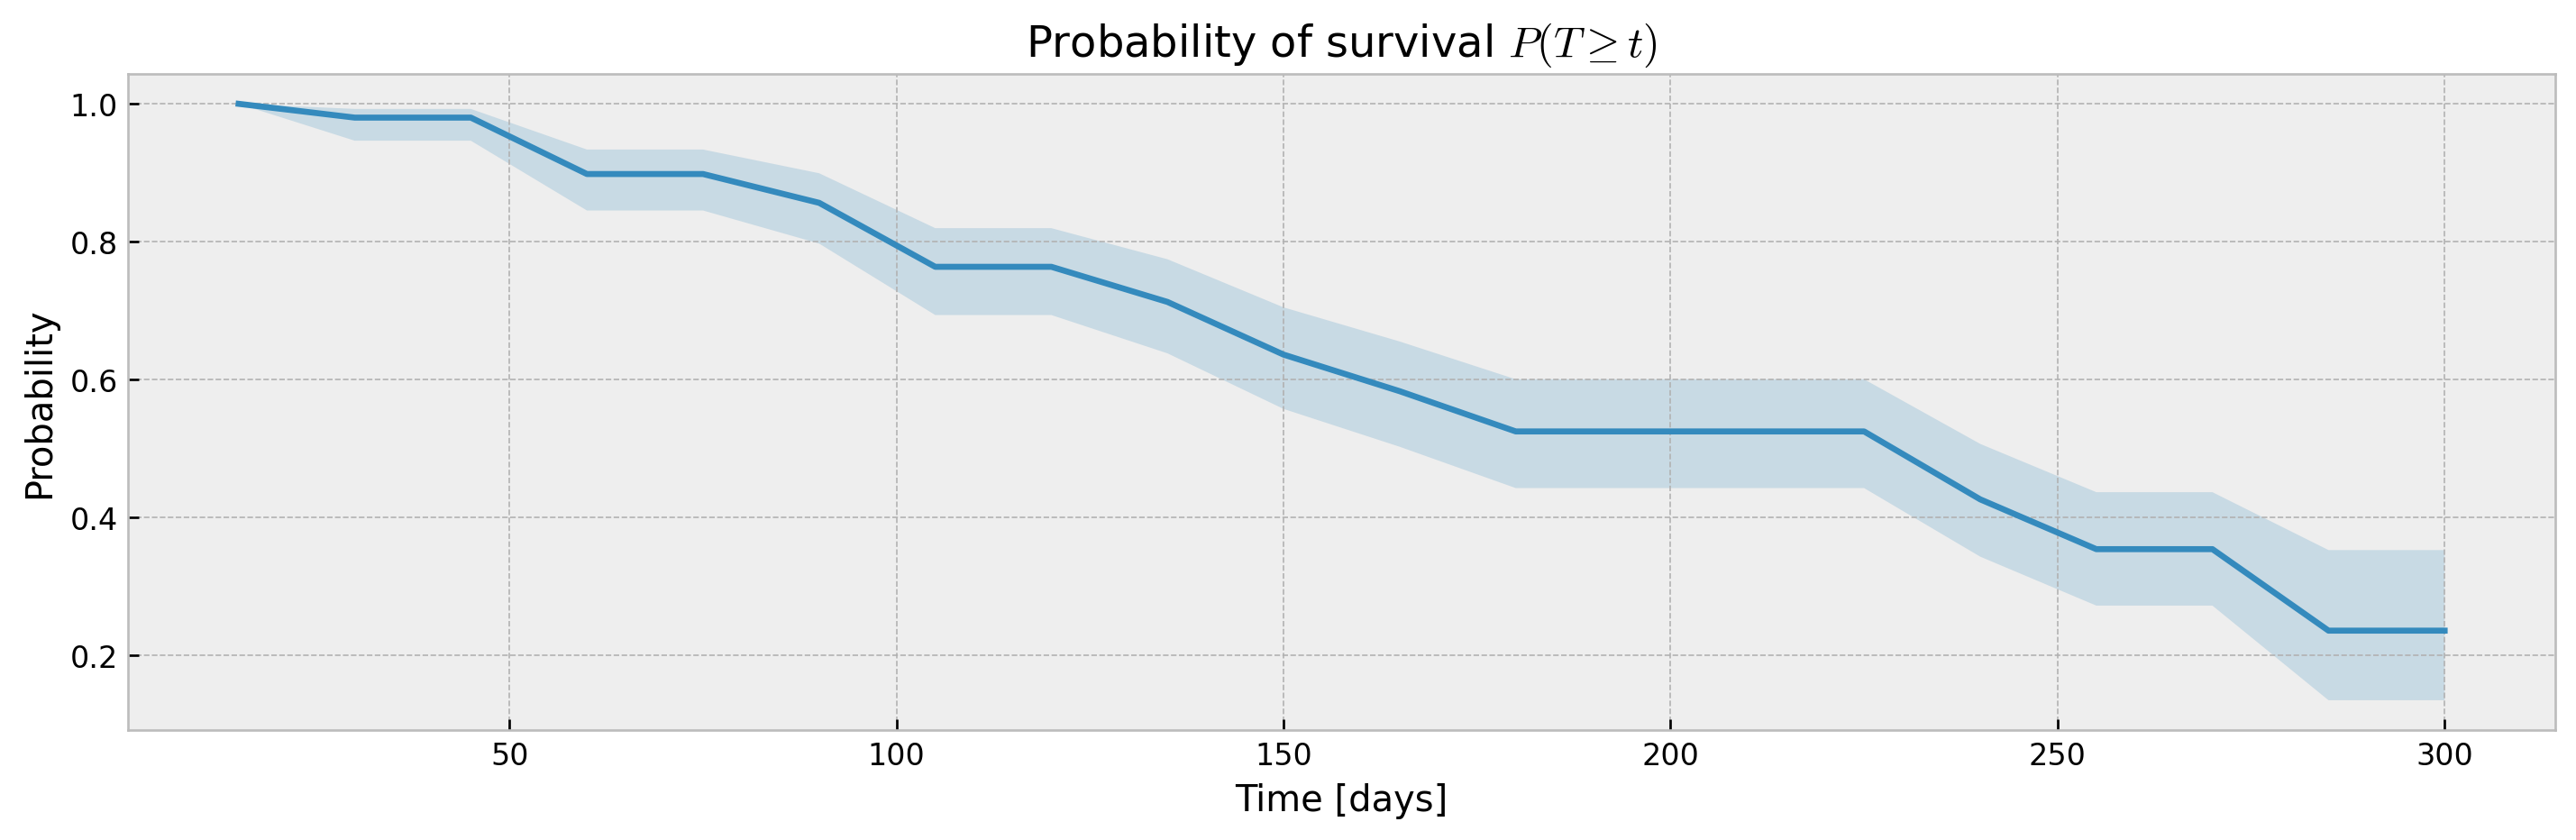

In [14]:
# fitting xgbse model
xgbse_model = XGBSEKaplanNeighbors(n_neighbors=50)
xgbse_model.fit(X_train, y_train, time_bins=TIME_BINS)

# predicting
mean, upper_ci, lower_ci = xgbse_model.predict(X_valid, return_ci=True)

# plotting CIs
plot_ci(mean, upper_ci, lower_ci)

`XGBSEDebiasedBCE` does not support estimation of confidence intervals out-of-the-box, but we provide the `XGBSEBootstrapEstimator` to get non-parametric confidence intervals. As the stacked logistic regressions BCE trains have access to all the data, confidence intervals are smaller:

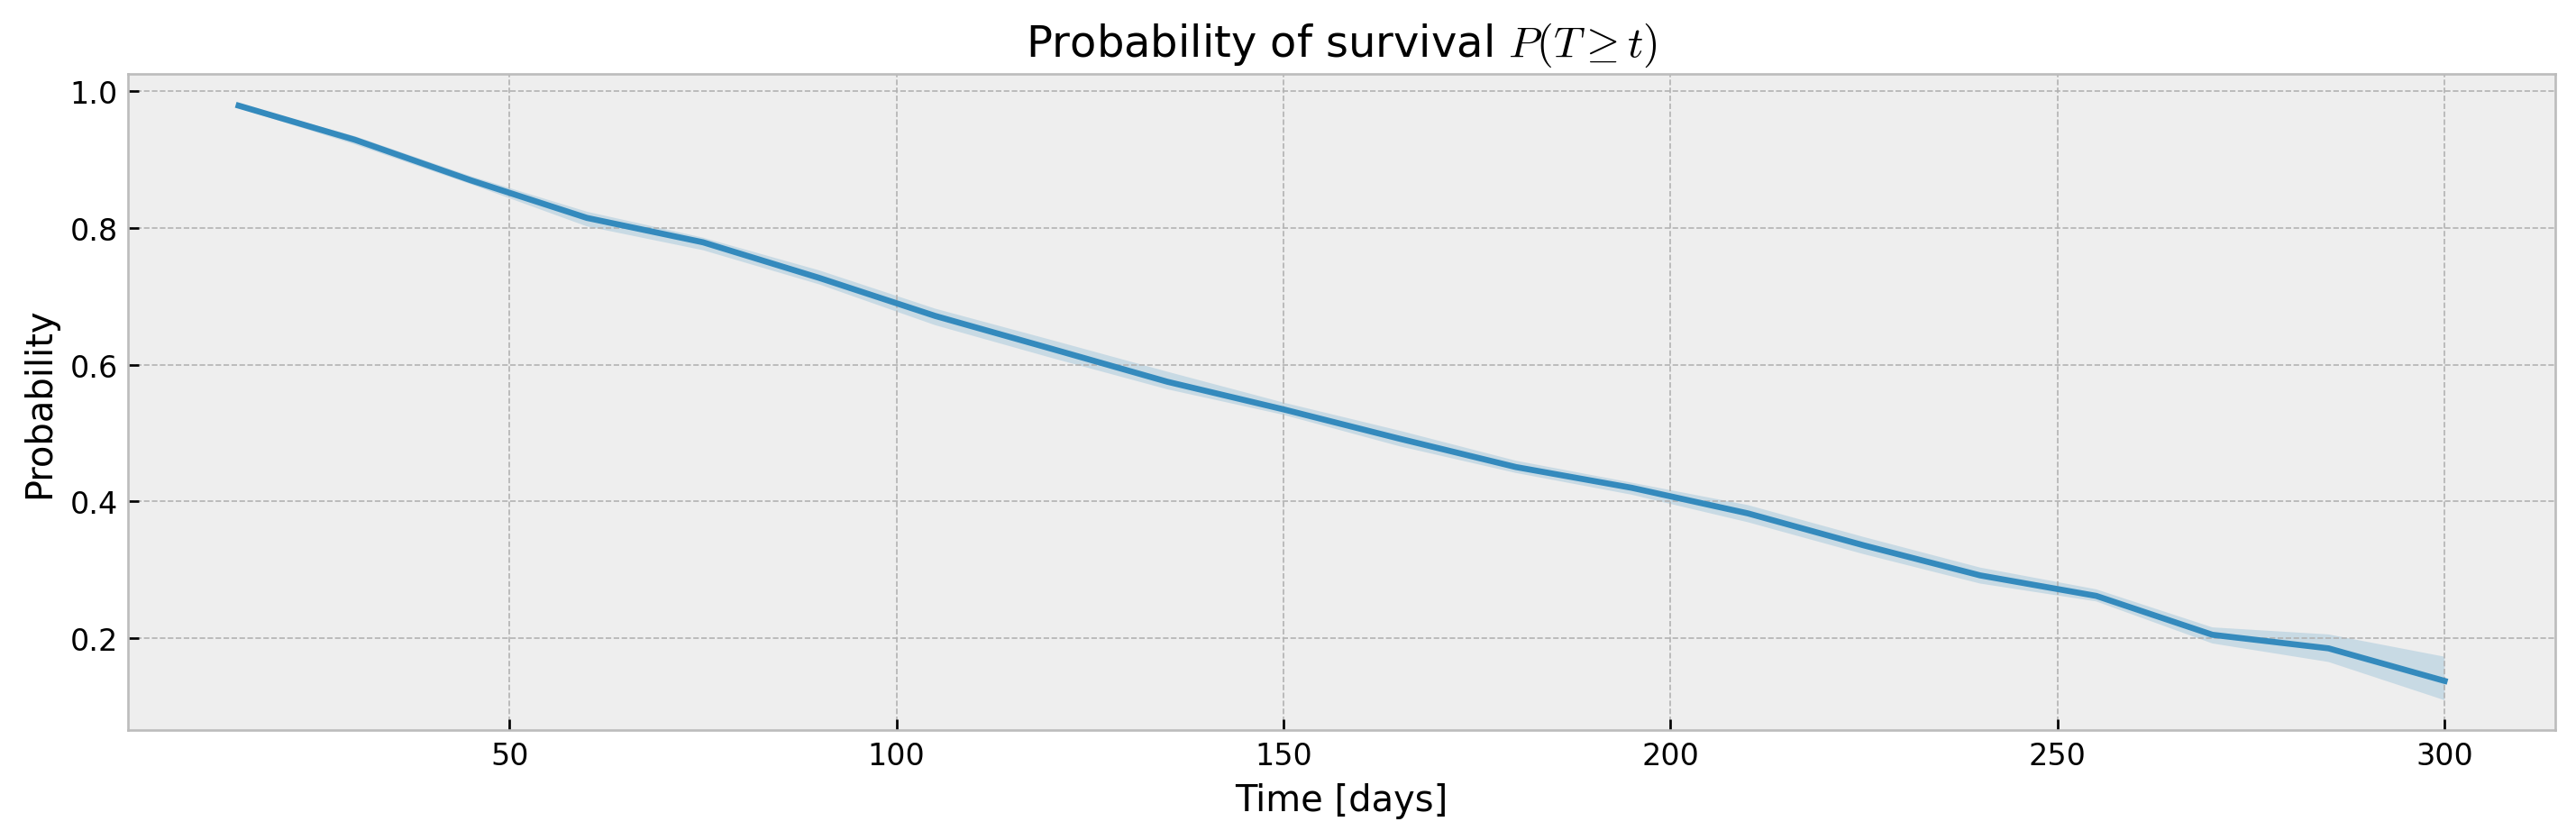

In [15]:
# base model as BCE
base_model = XGBSEDebiasedBCE(PARAMS_XGB_AFT, PARAMS_LR)

# bootstrap meta estimator
bootstrap_estimator = XGBSEBootstrapEstimator(base_model, n_estimators=20)

# fitting the meta estimator
bootstrap_estimator.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    early_stopping_rounds=10,
    time_bins=TIME_BINS,
)

# predicting
mean, upper_ci, lower_ci = bootstrap_estimator.predict(X_valid, return_ci=True)

# plotting CIs
plot_ci(mean, upper_ci, lower_ci)

The bootstrap abstraction can be used for `XBGSEKaplanTree` and `XBGSEKaplanNeighbors` as well, however, the confidence interval will be estimated via bootstrap only (not Exponential Greenwood formula):

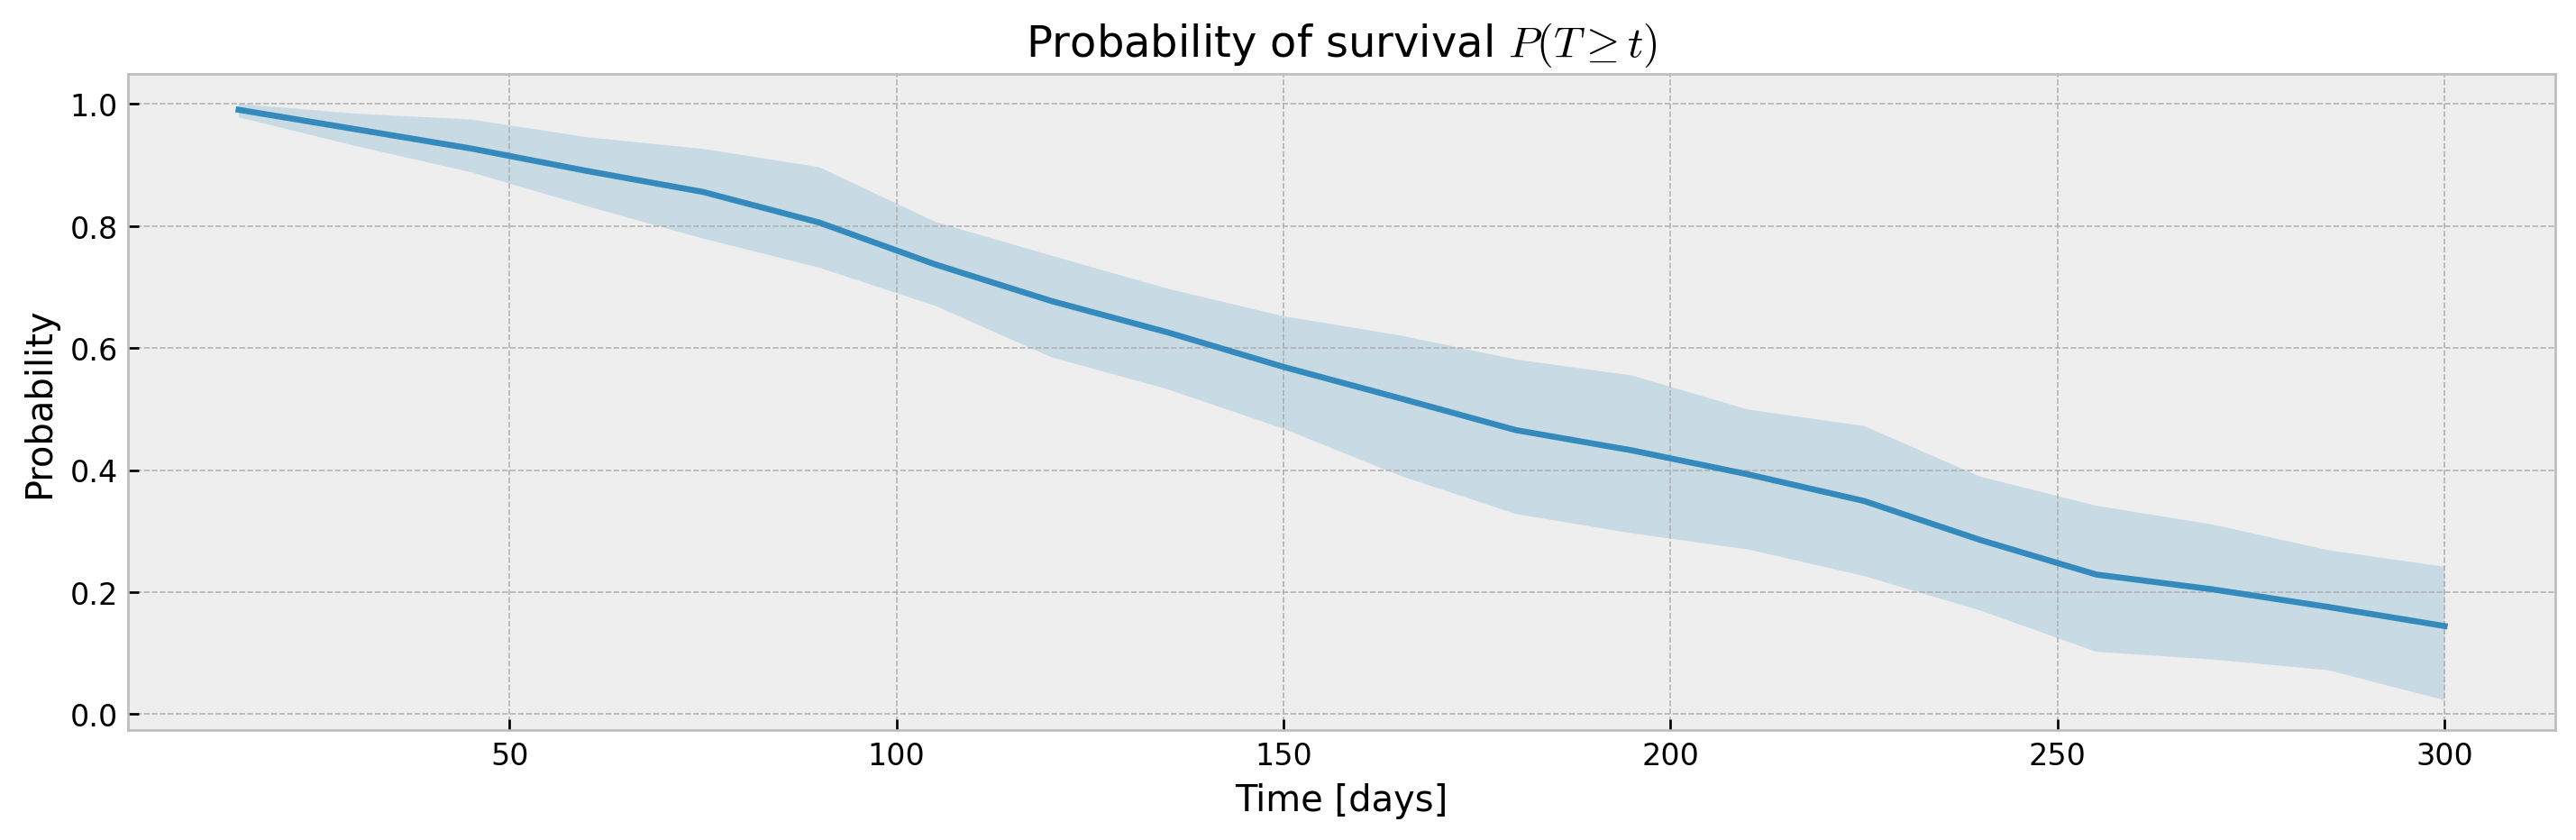

In [16]:
# base model
base_model = XGBSEKaplanTree(PARAMS_TREE)

# bootstrap meta estimator
bootstrap_estimator = XGBSEBootstrapEstimator(base_model, n_estimators=100)

# fitting the meta estimator
bootstrap_estimator.fit(
    X_train,
    y_train,
    time_bins=TIME_BINS,
)

# predicting
mean, upper_ci, lower_ci = bootstrap_estimator.predict(X_valid, return_ci=True)

# plotting CIs
plot_ci(mean, upper_ci, lower_ci)

With a sufficiently large `n_estimators`, interval width shouldn't be much different, with the added benefit of model stability and improved accuracy. Addittionaly, `XGBSEBootstrapEstimator` allows building confidence intervals for interval probabilities (not supported for Exponential Greenwood):

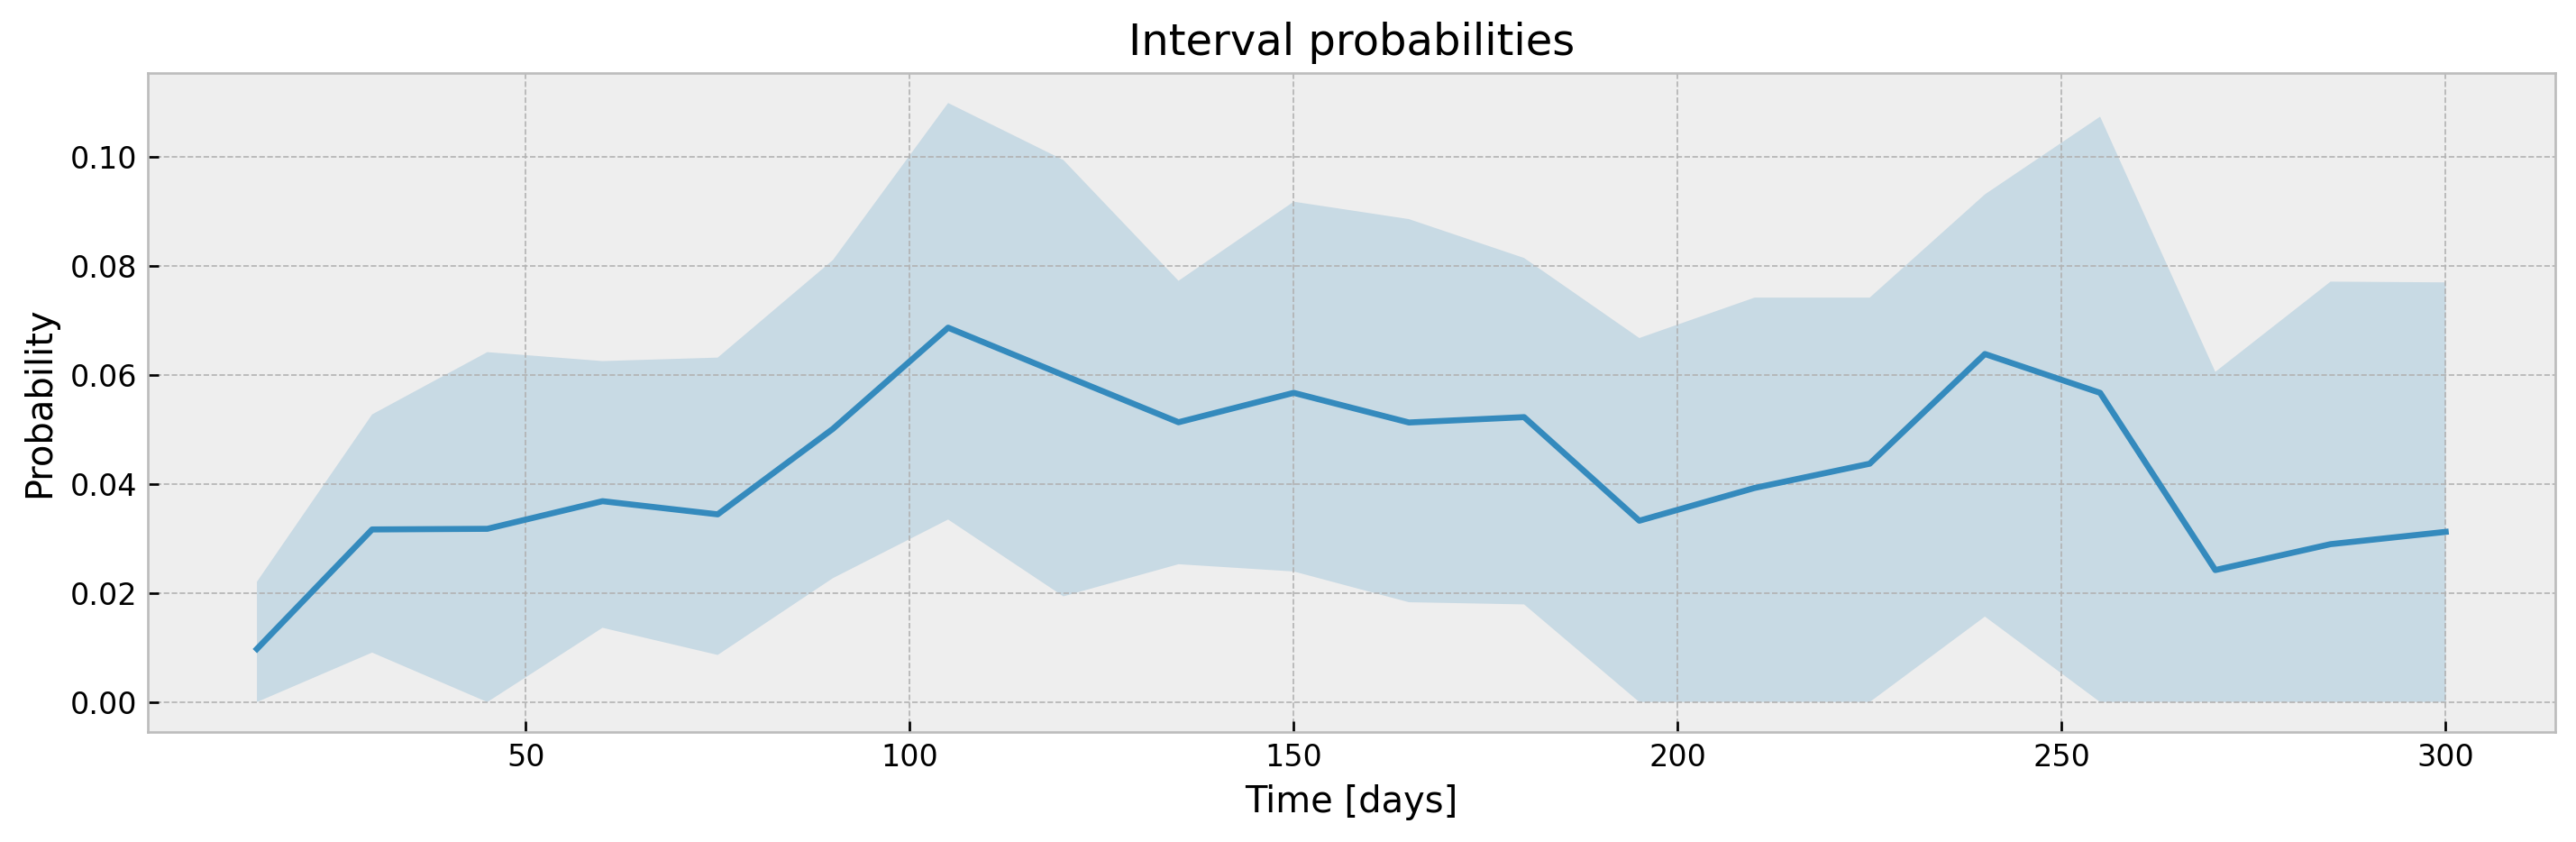

In [17]:
# predicting
mean, upper_ci, lower_ci = bootstrap_estimator.predict(
    X_valid,
    return_ci=True,
    return_interval_probs=True
)

# plotting CIs
plot_ci(mean, upper_ci, lower_ci, title='Interval probabilities')

The parameter `ci_width` controls the width of the confidence interval. For `XGBSEKaplanTree` it should be passed at `.fit()`, as KM curves are pre-calculated for each leaf at fit time to avoid storing training data.

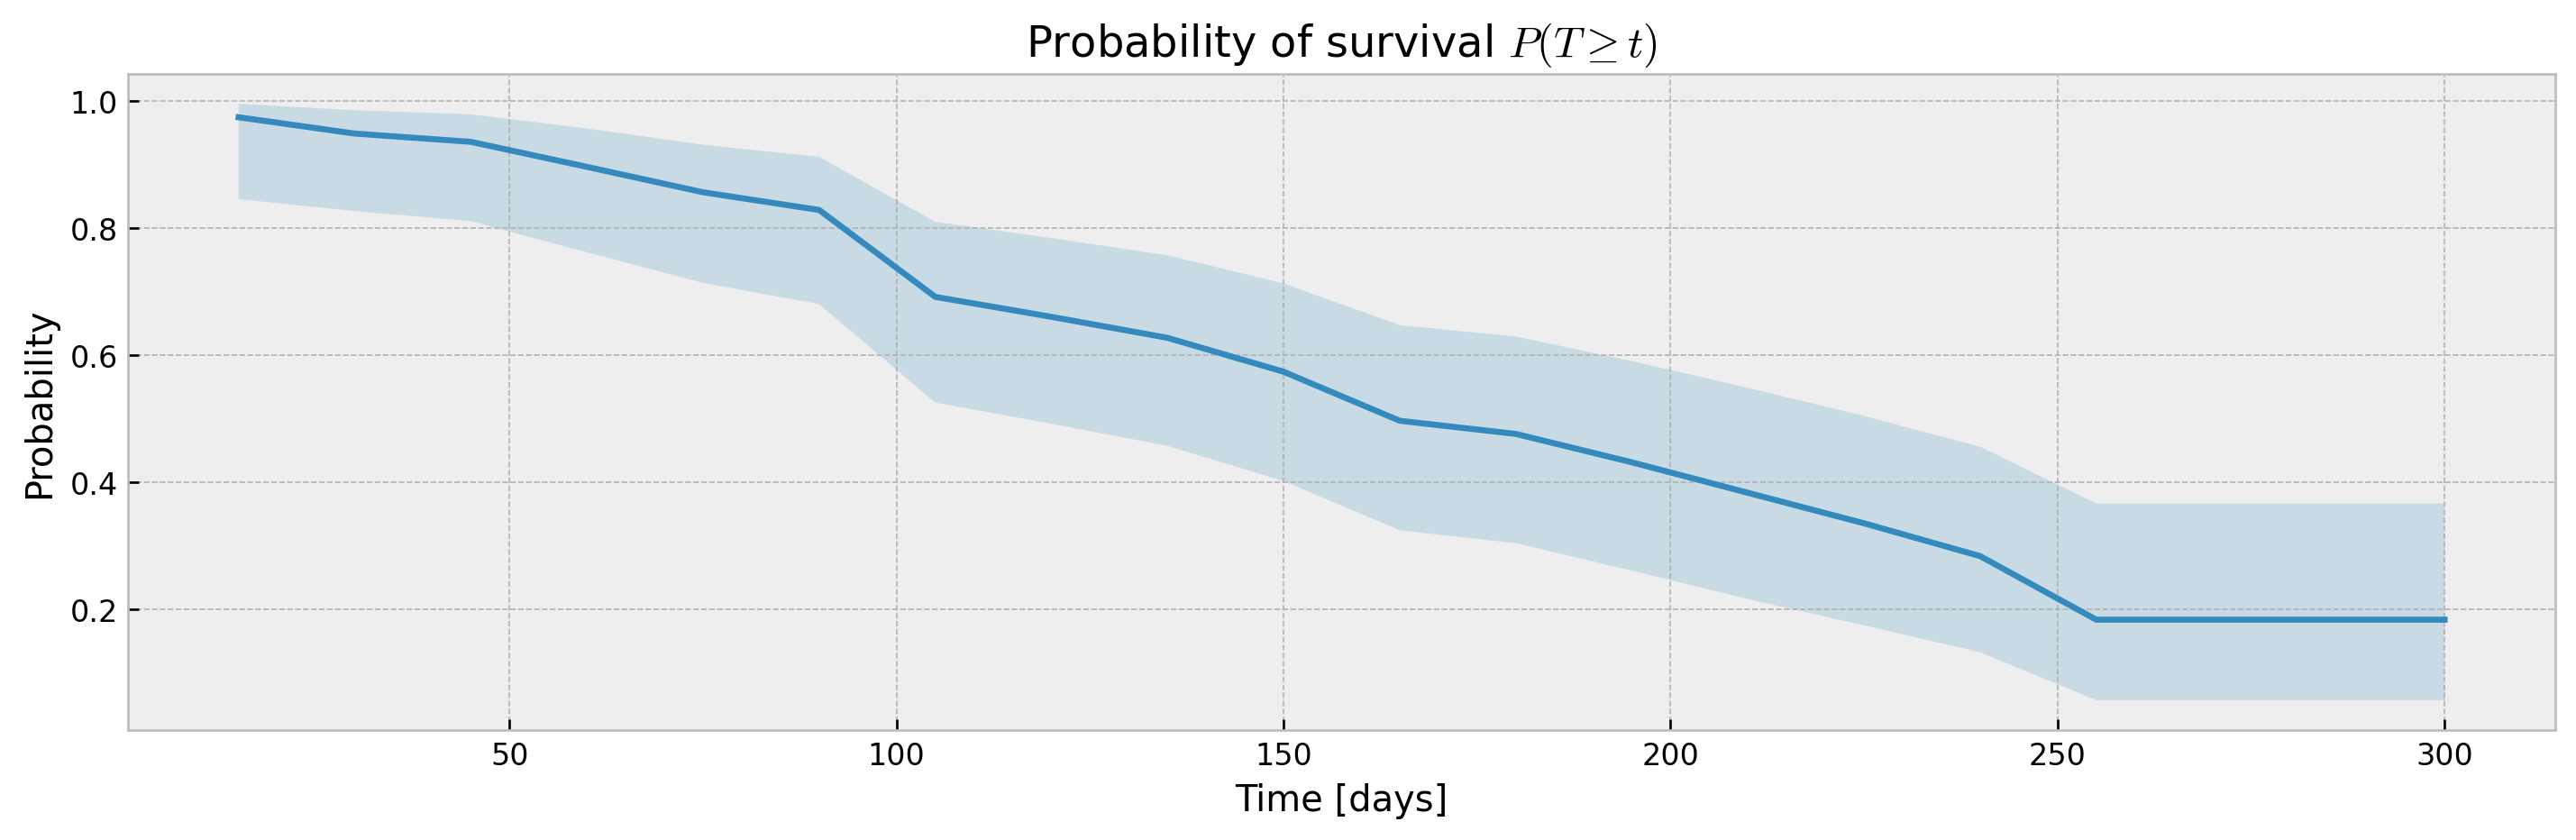

In [18]:
# fitting xgbse model
xgbse_model = XGBSEKaplanTree(PARAMS_TREE)
xgbse_model.fit(X_train, y_train, time_bins=TIME_BINS, ci_width=0.99)

# predicting
mean, upper_ci, lower_ci = xgbse_model.predict(X_valid, return_ci=True)

# plotting CIs
plot_ci(mean, upper_ci, lower_ci)

For other models (`XGBSEKaplanNeighbors` and `XGBSEBootstrapEstimator`) it should be passed at `.predict()`.

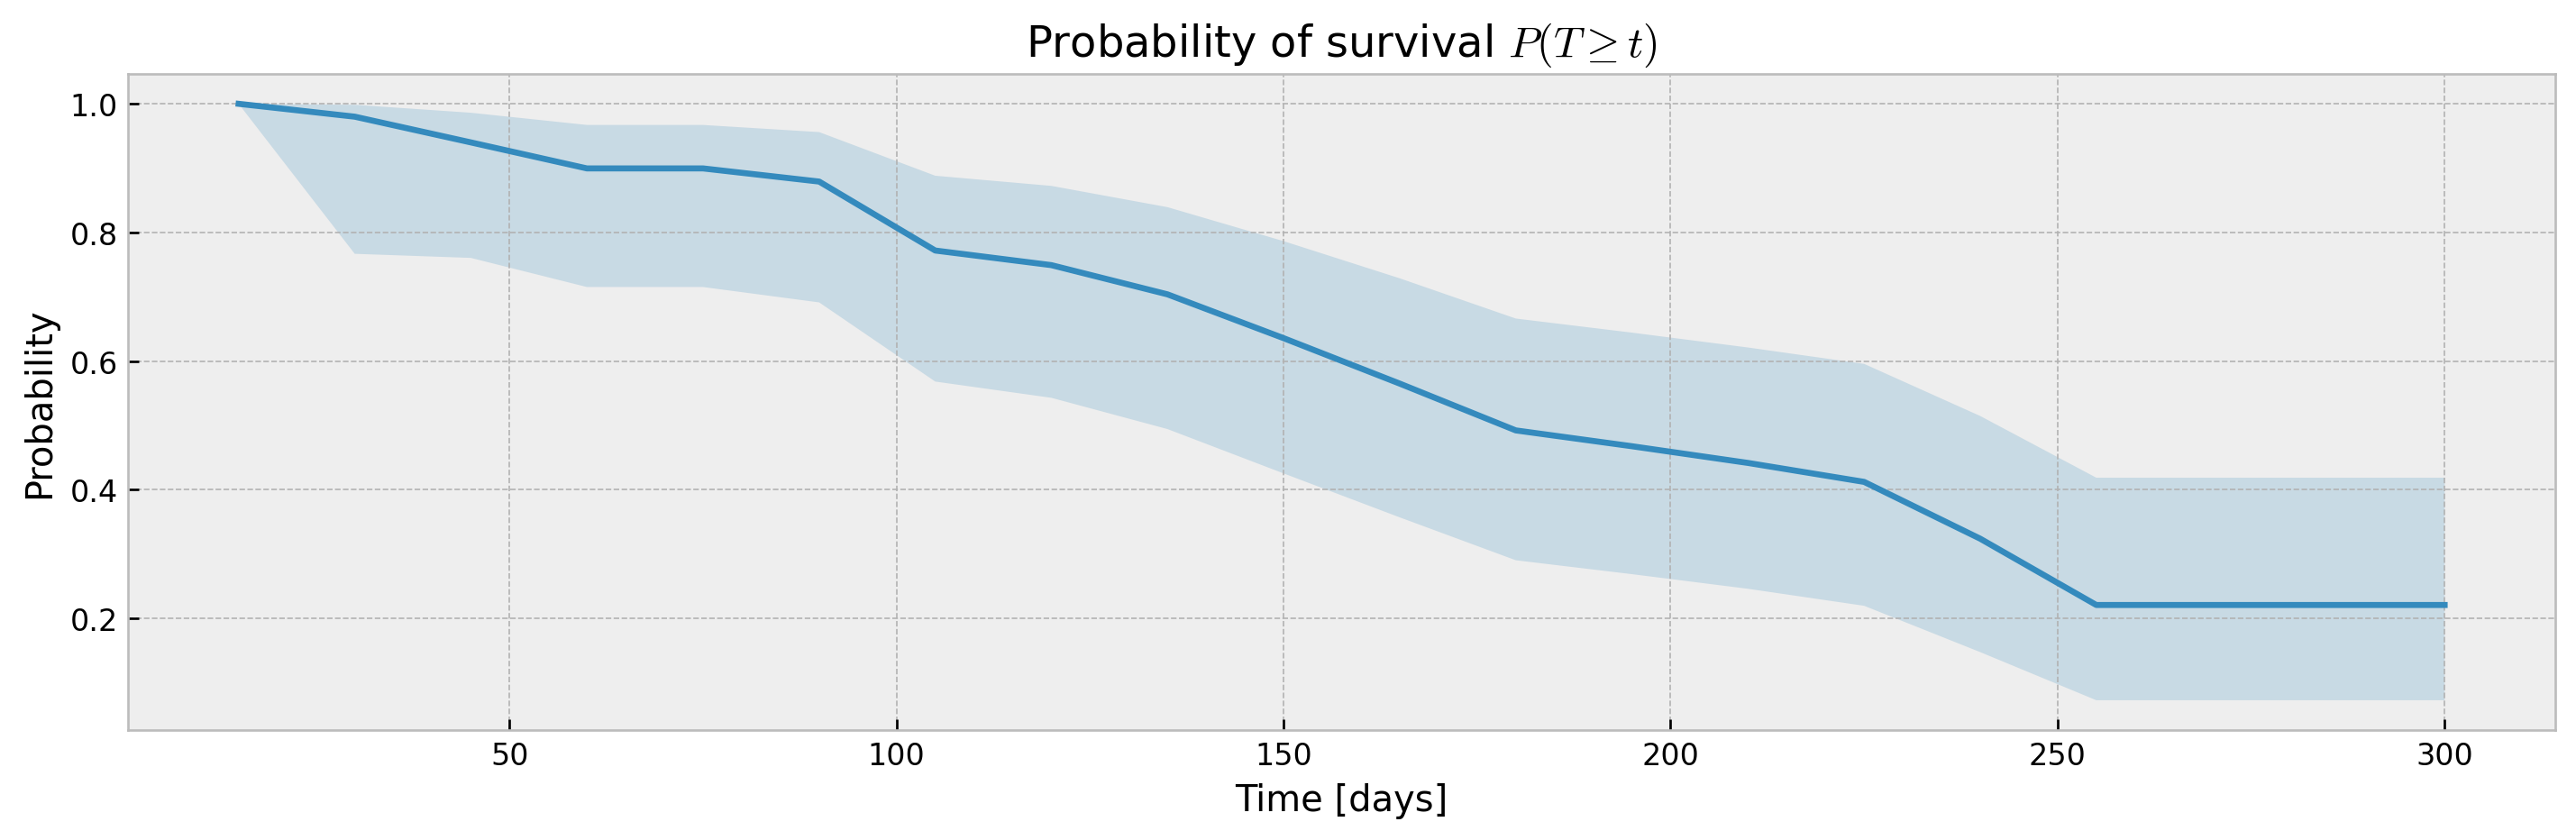

In [19]:
# base model
model = XGBSEKaplanNeighbors(PARAMS_XGB_AFT, N_NEIGHBORS)

# fitting the meta estimator
model.fit(
    X_train, y_train,
    validation_data = (X_valid, y_valid),
    early_stopping_rounds=10,
    time_bins=TIME_BINS
)

# predicting
mean, upper_ci, lower_ci = model.predict(X_valid, return_ci=True, ci_width=0.99)

# plotting CIs
plot_ci(mean, upper_ci, lower_ci)

### *Extrapolation*

We provide an extrapolation interface, to deal with cases where the survival curve does not end at 0 due to censoring. Currently the implementation only supports extrapolation assuming constant risk.

In [20]:
from xgbse.extrapolation import extrapolate_constant_risk

# predicting
survival = bootstrap_estimator.predict(X_valid)

# extrapolating
survival_ext = extrapolate_constant_risk(survival, 450, 11)

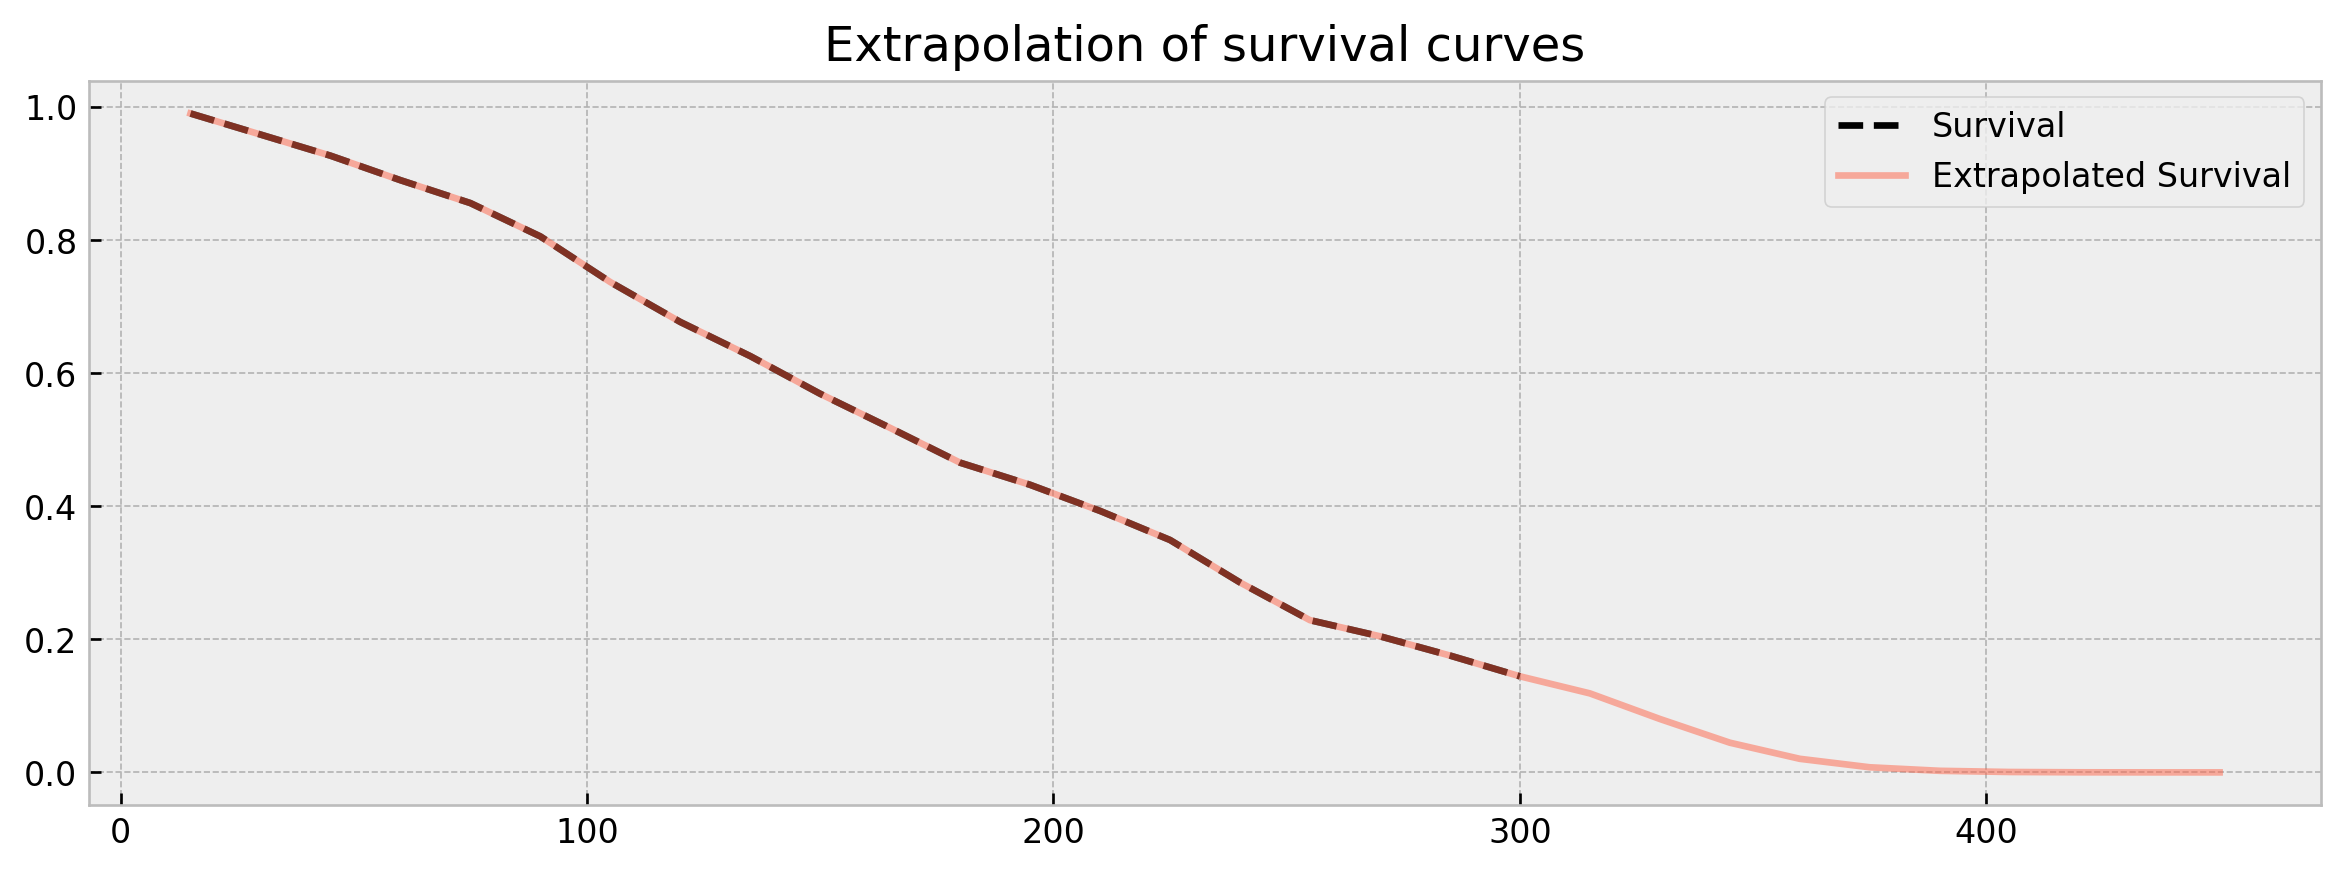

In [21]:
# plotting extrapolation #

plt.figure(figsize=(12,4), dpi=120)

plt.plot(
    survival.columns,
    survival.iloc[42],
    'k--',
    label='Survival'
)

plt.plot(
    survival_ext.columns,
    survival_ext.iloc[42],
    'tomato',
    alpha=0.5,
    label='Extrapolated Survival'
)

plt.title('Extrapolation of survival curves')
plt.legend()

### *Early stopping*

A simple interface to `xgboost` early stopping is provided:

In [22]:
# fitting with early stopping
xgb_model = XGBSEDebiasedBCE(PARAMS_XGB_AFT, PARAMS_LR)

xgb_model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    early_stopping_rounds=10,
    time_bins=TIME_BINS,
    verbose_eval=50
)

[0]	validation-aft-nloglik:27.22550
Will train until validation-aft-nloglik hasn't improved in 10 rounds.
[50]	validation-aft-nloglik:4.54571
[100]	validation-aft-nloglik:4.03080
Stopping. Best iteration:
[105]	validation-aft-nloglik:4.02175



XGBSEDebiasedBCE(xgb_params={'aft_loss_distribution': 'normal',
                             'aft_loss_distribution_scale': 0.5,
                             'booster': 'dart', 'colsample_bynode': 0.5,
                             'eval_metric': 'aft-nloglik',
                             'learning_rate': 0.05, 'max_depth': 8,
                             'min_child_weight': 50,
                             'objective': 'survival:aft', 'subsample': 0.5,
                             'tree_method': 'hist'})

### *Explainability through prototypes*

`xgbse` also provides explainability through prototypes, searching the embedding for neighbors. The idea behind this is to explain model predictions with real samples, providing solid ground to justify them (see [8]). The method `.get_neighbors()` returns the `n_neighbors` nearest neighbors in `index_data` for each sample in `query_data`:

In [23]:
neighbors = xgb_model.get_neighbors(
    query_data=X_valid,
    index_data=X_train,
    n_neighbors=10
)
neighbors.head(5)

,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_6,neighbor_7,neighbor_8,neighbor_9,neighbor_10
1225,1151,56,1895,1274,880,1046,1087,1127,1115,1675
111,1090,4,649,892,1743,1143,1214,965,940,1454
554,9,627,1031,1460,816,1236,1888,1623,1654,229
526,399,242,870,1529,1042,1640,1426,968,357,1235
1313,1388,1229,992,599,1121,1336,541,119,1793,1811


This way, we can inspect neighbors of a given sample to try to explain predictions. For instance, we can choose a `reference` and check that there actually are similar elements to it:

In [24]:
i = 0

reference = X_valid.iloc[i]
reference.name = 'reference'
train_neighs = X_train.loc[neighbors.iloc[i]]

pd.concat([reference.to_frame().T, train_neighs]).reset_index()

,index,x0,x1,x2,x3,x4,x5,x6,x7,x8
0,reference,5.729280,5.694927,10.782435,5.566500,1.0,1.0,0.0,1.0,86.260002
1,1151,5.793584,5.878354,11.071033,5.454103,1.0,1.0,0.0,1.0,82.339996
2,56,6.134690,6.860185,10.767976,5.582559,1.0,1.0,0.0,1.0,85.940002
3,1895,5.484297,5.362111,10.479775,5.538042,1.0,1.0,0.0,1.0,85.389999
4,1274,5.733367,7.002502,10.033753,5.568994,1.0,1.0,0.0,1.0,85.489998
5,880,5.924964,5.441526,10.568412,5.561672,0.0,0.0,0.0,1.0,86.040001
6,1046,5.818685,6.095517,11.405285,5.436041,0.0,0.0,0.0,1.0,85.169998
7,1087,5.768726,8.030006,10.543572,5.521380,1.0,0.0,0.0,1.0,86.750000
8,1127,5.538732,5.131131,11.105591,5.523721,1.0,1.0,0.0,1.0,86.279999
9,1115,5.702103,5.310441,14.457623,5.533638,1.0,0.0,0.0,1.0,87.180000


We also can compare the Kaplan-Meier curve from the neighbors to the BCE prediction, checking that it is inside the confidence interval:

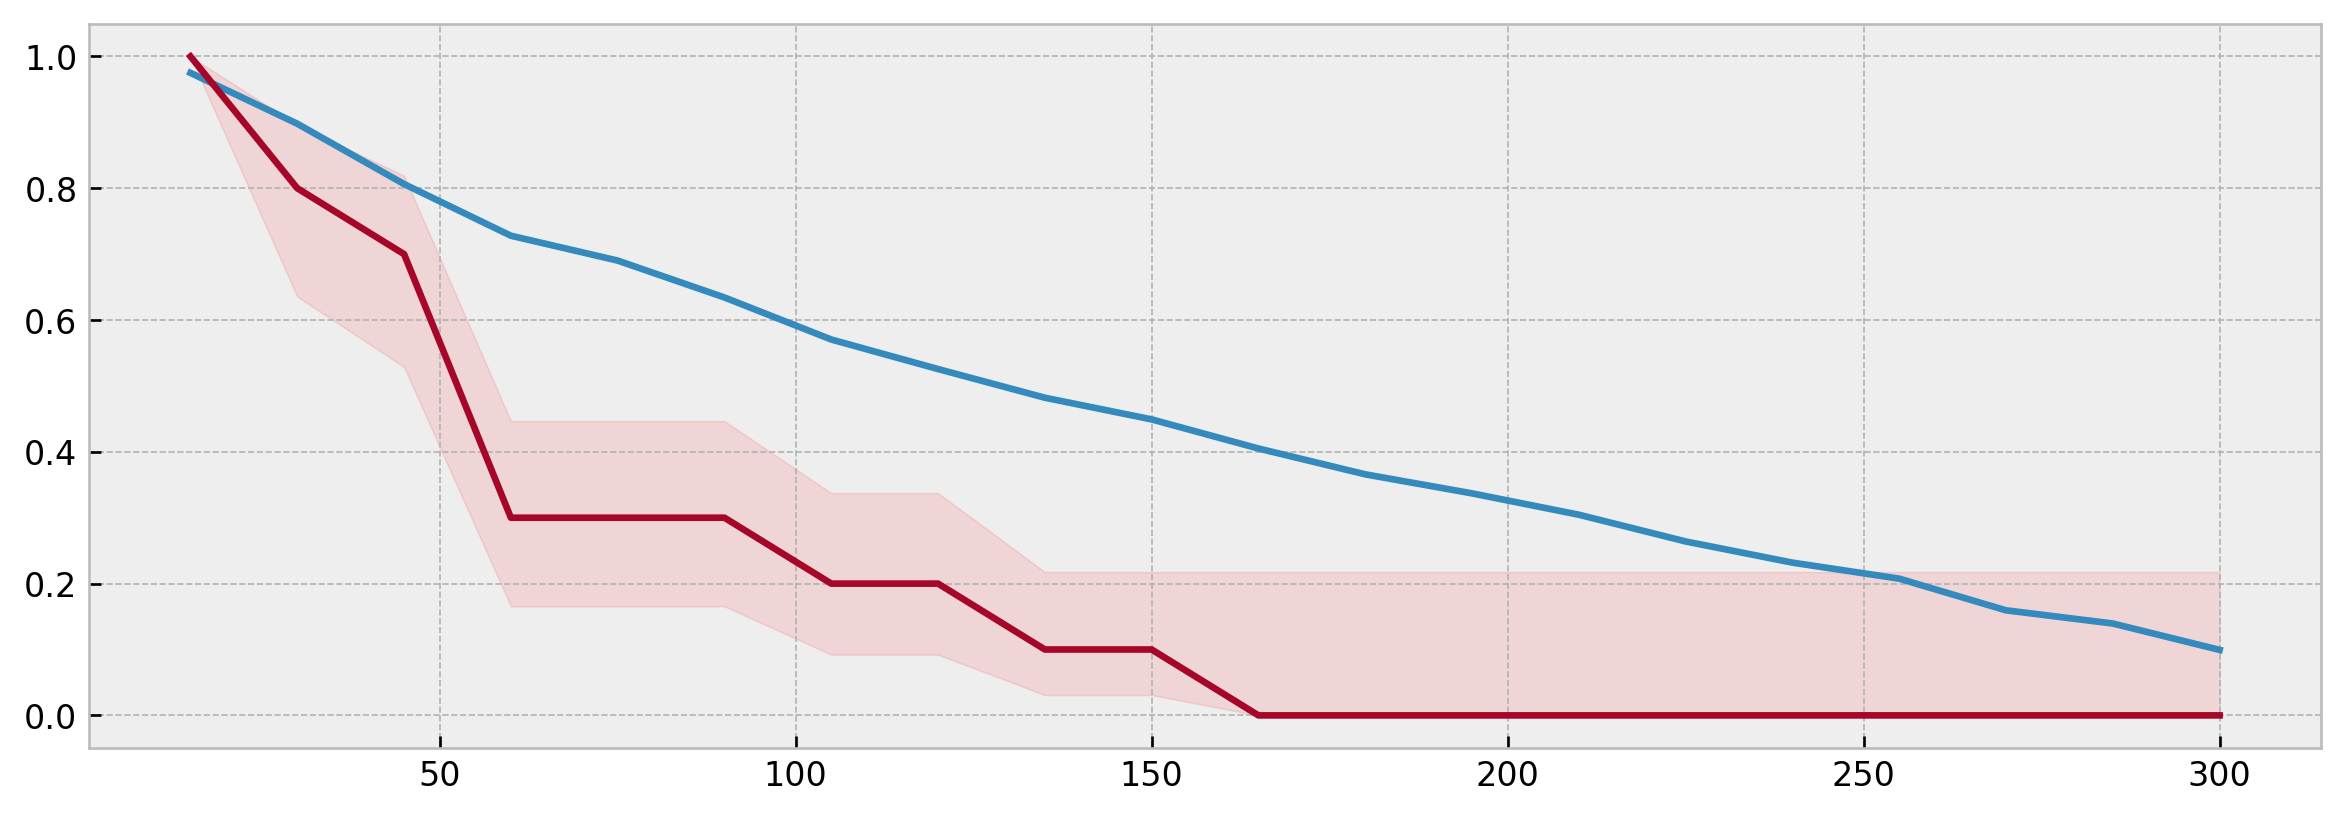

In [25]:
from xgbse.non_parametric import calculate_kaplan_vectorized

mean, high, low = calculate_kaplan_vectorized(
    np.array([y['c2'][neighbors.iloc[i]]]),
    np.array([y['c1'][neighbors.iloc[i]]]),
    TIME_BINS
)

model_surv = xgb_model.predict(X_valid)

plt.figure(figsize=(12,4), dpi=120)
plt.plot(model_surv.columns, model_surv.iloc[i])
plt.plot(mean.columns, mean.iloc[0])
plt.fill_between(mean.columns, low.iloc[0], high.iloc[0], alpha=0.1, color='red')

Specifically, for `XBGSEKaplanNeighbors` prototype predictions and model predictions should match exactly.

### **Metrics**

We made our own metrics submodule to make the lib self-contained. `xgbse.metrics` implements C-index, Brier Score and D-Calibration from [9].

In [26]:
# training model
xgbse_model = XGBSEKaplanNeighbors(PARAMS_XGB_AFT, n_neighbors=30)
xgbse_model.fit(
    X_train, y_train,
    validation_data = (X_valid, y_valid),
    early_stopping_rounds=10,
    time_bins=TIME_BINS
)

# predicting
preds = xgbse_model.predict(X_valid)

In [27]:
# importing metrics
from xgbse.metrics import (
    concordance_index,
    approx_brier_score,
    dist_calibration_score
)

# running metrics
print(f'C-index: {concordance_index(y_valid, preds)}')
print(f'Avg. Brier Score: {approx_brier_score(y_valid, preds)}')
print(f"""D-Calibration: {dist_calibration_score(y_valid, preds) > 0.05}""")

C-index: 0.6459408536085852
Avg. Brier Score: 0.17187412988709133
D-Calibration: True


As metrics follow the `score_func(y, y_pred, **kwargs)` pattern, we can use the sklearn model selection module easily:

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

xgbse_model = XGBSEKaplanTree(PARAMS_TREE)
results = cross_val_score(xgbse_model, X, y, scoring=make_scorer(approx_brier_score))
results

array([0.17432953, 0.15907712, 0.13783666, 0.16770409, 0.16792016])

## References

[1] [Practical Lessons from Predicting Clicks on Ads at Facebook](https://research.fb.com/wp-content/uploads/2016/11/practical-lessons-from-predicting-clicks-on-ads-at-facebook.pdf): paper that shows how stacking boosting models with logistic regression improves performance and calibration

[2] [Feature transformations with ensembles of trees](https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html): scikit-learn post showing tree ensembles as feature transformers

[3] [Calibration of probabilities for tree-based models](https://gdmarmerola.github.io/probability-calibration/): blog post showing a practical example of tree ensemble probability calibration with a logistic regression

[4] [Supervised dimensionality reduction and clustering at scale with RFs with UMAP](https://gdmarmerola.github.io/umap-supervised-embeddings/): blog post showing how forests of decision trees act as noise filters, reducing intrinsic dimension of the dataset.

[5] [Learning Patient-Specific Cancer Survival Distributions as a Sequence of Dependent Regressors](http://www.cs.cornell.edu/~cnyu/papers/nips11_survival.pdf): inspiration for the BCE method (multi-task logistic regression)

[6] [The Brier Score under Administrative Censoring: Problems and Solutions](https://arxiv.org/pdf/1912.08581.pdf): reference to BCE (binary cross-entropy survival method).

[7] [The Greenwood and Exponential Greenwood Confidence Intervals in Survival Analysis](https://www.math.wustl.edu/~sawyer/handouts/greenwood.pdf): reference we used for the Exponential Greenwood formula from KM confidence intervals

[8] [Tree Space Prototypes: Another Look at Making Tree Ensembles Interpretable](https://arxiv.org/abs/1611.07115): paper showing a very similar method for extracting prototypes

[9] [Effective Ways to Build and Evaluate Individual Survival Distributions](https://arxiv.org/pdf/1811.11347.pdf): paper showing how to validate survival analysis models with different metrics